# Homework 3：Actor-Critic Algorithm and Dyna Q algorithm
## Due: Due: 23:59:59 (GMT +08:00), April 25, 2025 ##
**The homework contains two parts：ActorCritic algorithm and Dyna Q algorithm. You need to implement the two alogithms and answer the questions.**

# Section 1 Dyna-Q and Dyna-Q+

### Environment--Maze problem

In the first simple maze problem shown in Figure 1 (**basic**), there are four actions, **up**, **down**, **right**, and **left**, which take the agent deterministically to the corresponding neighboring states, except when movement is blocked by an obstacle or the outer boundary of the maze, in which case the agent remains where it is. 

Reward is zero on all state-action pairs, except those transiting to the goal state, on which the reward is **+1**, i.e., **r(s, a) = 1** when the
**next state s′ = G** and **r(s, a) = 0 otherwise**.

After reaching the goal state (G), the agent returns to the start state (S) to begin a new episode.

!["figure 1"](./pic1.png)

*Figure 1*

In the second blocking maze problem (**blocking**) shown in Figure 2, initially, there is a short path from start to goal, along the right-hand side boundary of the maze, as shown in the left subfigure of Figure 2. 

After 5000 time steps, the short path is “blocked”, and a longer path is opened up along the left-hand side boundary of the maze, as shown in the right subfigure of Figure 2. Other basic settings are the same as the first simple maze problem.

!["figure 2"](./pic2.png)

*Figure 2*

In the third shortcut maze problem (**cut**) shown in Figure 3, initially, the optimal path is to go around the left side of the boundary (left subfigure of Figure 3). 

After 3000 time steps, however, a shorter path is opened up along the right side, without changing the original path (right subfigure of Figure3). And other basic settings are the same as the first problem.

!["figure 3"](./pic3.png)

*Figure 3*


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time
class Maze:
    def __init__(self, ncol = 9, nrow = 6, model = "basic"):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # the current position (x) of agent 
        self.y = self.nrow - 1  # the current position (y) of agent
        self.time_counter = 0
        self.model = model
        if model == "basic":
            self.barrier = [[2, 2], [2, 3], [2, 4], [5, 1], [7, 3], [7, 4], [7, 5]]
            self.start = [0, 3]
            self.end = [8, 5]
        if model == "blocking":
            self.barrier = [[0, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
            self.start = [3, 0]
            self.end = [8, 5]
        if model == "cut":
            self.barrier = [[8, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
            self.start = [3, 0]
            self.end = [8, 5]

    def step(self, action):  # 

        # 4 kinds of actions: change[0]:up , change[1]:down, change[2]:left, change[3]:right  
        
        
        # original (0,0) on the top left
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        newx = min(self.ncol - 1, max(0, self.x + change[action][0]))
        newy = min(self.nrow - 1, max(0, self.y + change[action][1]))
        if [newx, newy] not in self.barrier:
            self.x = newx
            self.y = newy
        next_state = self.y * self.ncol + self.x
        reward = 0
        done = False
        if self.x==self.end[0] and self.y==self.end[1]:  # next position is the terminal
            done = True
            reward = 1
        #print(self.x, self.y)
        self.time_counter += 1
        if self.time_counter > 5000 and self.model == "blocking":
            self.barrier = [[8, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
        if self.time_counter > 3000 and self.model == "cut":
            self.barrier = [[1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
        return next_state, reward, done   # whether done after taking this step

    def reset(self):  # return to start point
        #self.time_counter = 0
        self.x = self.start[0]
        self.y = self.start[1] 
        return self.y * self.ncol + self.x

### In this part, we try to implement two algorithms：(A) Dyna-Q and (B) Dyna-Q+

#### Dyna-Q

The Dyna-Q algorithm is to repeat the following steps: (1) Learning and (2) Planning

Learning step is the same as Q-learning , at current state $S$ , we take action $A$ with $\epsilon-greedy$ policy ,then we get rewards $R$ and next state $S'$ from environment. We update the Q-table by the following formula: 
$$ Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma  max_{a} Q(S',a)- Q(S,A)] $$

Then we predict state transition as following:
$$Model(S,A) \leftarrow R,S'$$

Planning does not need to interact with the environment , every planning step samples a visited pair $(S,A)$ firstly, obtain relevant $(R,S')$ from $Model(R,A)$ ,and update Q-table by following formula , the planning step will repeat n times:
$$ Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma  max_{a} Q(S',a)- Q(S,A)] $$

**Coding exercise.** Here you are require to implete $q_learning()$ and $update()$ in Class DynaQ.


In [7]:
class DynaQ:
    """ Dyna-Q """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # initial Q table
        self.n_action = n_action  # num of actions
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # epsilon-greedy

        self.n_planning = n_planning  # num of times to conduct q-planning
        self.model = dict()  #  env model

    def check(self, state):
        if self.Q_table[state][0] == self.Q_table[state][1] == self.Q_table[state][2] == self.Q_table[state][3]:
            return True
        return False

    def take_action(self, state):  #epsilon greedy
        if np.random.random() < self.epsilon or self.check(state):
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        """ ------------- Programming 1: implement the updating of the Q table for Q-learning ------------- """
        """ YOUR CODE HERE """
        self.Q_table[s0, a0] = self.Q_table[s0, a0] + self.alpha * (r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0, a0]) 
        """ ------------- Programming 1 ------------- """

    def update(self, s0, a0, r, s1):
        """ ------------- Programming 2: implement the updating of the Q table for DynaQ (you may use the function q_learning) ------------- """
        """ YOUR CODE HERE """
        self.q_learning(s0, a0, r, s1) # 用环境数据更新Q
        self.model[(s0,a0)] = (r, s1) # 用环境数据更新model(确定性环境)
        for i in range(self.n_planning): # planning，根据模型随机选择(s,a)并更新Q
            s, a = random.choice(list(self.model.keys()))   # random choice viewed (s,a)
            r, ss = self.model[(s,a)] # take action in the model
            self.q_learning(s, a, r, ss)
        
        """ ------------- Programming 2 ------------- """


#### Dyna-Q+

Dyna-Q+ is similar to Dyna-Q , the only difference between them is the rewards fountion in planning step . We take a new reward $r = r + c \sqrt t$ , $c$ is a exploration factor and $t$ is  the time since agent last reached state S

**Coding exercise.** Simiarily , you are require to implete $q_learning()$ and $update()$ in Class $DynaQ_Plus$

In [27]:
class DynaQ_Plus:
    """ Dyna-Q+ """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 kappa,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # initial Q table
        self.n_action = n_action  # num of actions
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # epsilon-greedy

        self.n_planning = n_planning  # num of times to conduct q-planning
        self.model = dict()  #

        self.time = 0
        self.kappa = kappa

    def check(self, state):
        if self.Q_table[state][0] == self.Q_table[state][1] == self.Q_table[state][2] == self.Q_table[state][3]:
            return True
        return False

    def take_action(self, state):  # epsilon greedy
        if np.random.random() < self.epsilon or self.check(state):
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    def q_learning(self, s0, a0, r, s1):
        """ ------------- Programming 1: implement the updating of the Q table for Q-learning ------------- """
        """ YOUR CODE HERE """
        # 如果(s,a)是第一次遇到，self.model里面不会有值，tao=self.time()
        # 如果(s,a)不是第一次遇到，tao=self.time-last_time
        self.Q_table[s0, a0] += self.alpha * (r  + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0, a0])  # update Q table with the real experience
        """ ------------- Programming 1 ------------- """

    def update(self, s0, a0, r, s1):
        """ ------------- Programming 2: implement the updating of the Q table for DynaQ (you may use the function q_learning) ------------- """
        """ Hint self.model can be in : {(s0,a): (r,s1,times)}"""
        """ YOUR CODE HERE """
        if (s0, a0) not in self.model:
            # 如果是第一次遇到，初始化上一次遇到的时间（0相当于没遇到）
            self.model[(s0, a0)] = [r, s1, 0]
        self.q_learning(s0, a0, r, s1)  # 用原始的r
        self.time += 1  # 更新时间
        self.model[(s0, a0)] = [r, s1, self.time]  #在变化的环境中，sa达到的ss和r是会改变的

        # self.q_learning(s0, a0, r, s1)  # 用原始的r
        # self.time += 1  # 更新时间
        # self.model[(s0, a0)] = [r, s1, self.time]  # 更新遇到的时间

        for i in range(self.n_planning):  # planning
            s, a = random.choice(list(self.model.keys()))  # random choice viewed (s,a)
            r, ss, last_time = self.model[(s, a)]  # take action in the model
            self.q_learning(s, a,
                            r + self.kappa * np.sqrt(self.time - last_time),
                            ss)

        """ ------------- Programming 2 ------------- """

## Running two algorithms in the Maze environment and  Visualization

Here, we try to run two algorithms in our environment. You should run the following code without editing and answer **Questions 1** based on the output. **Your output will be one of the criteria we use to score**.


You also can change the hyperparameters privately to get a better understanding of these two algorithms. 

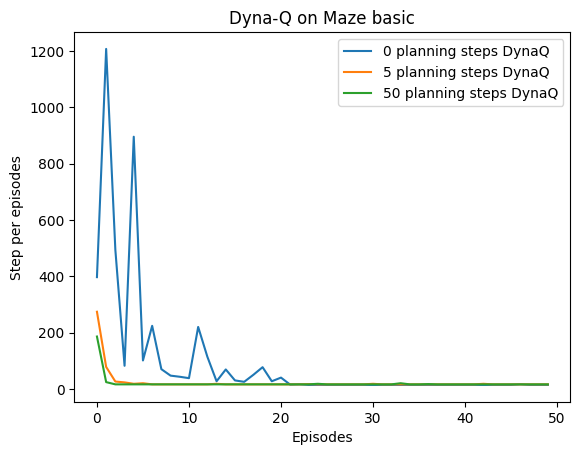

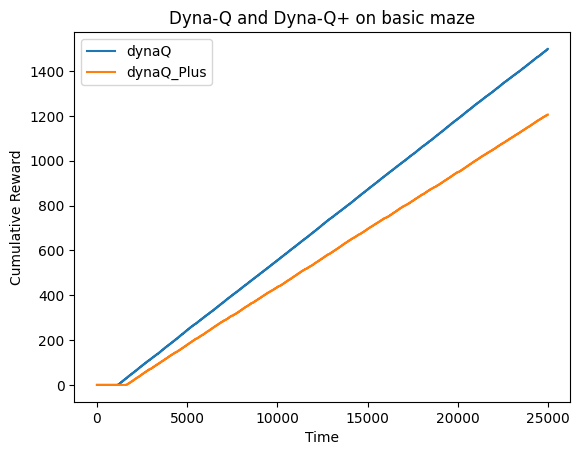

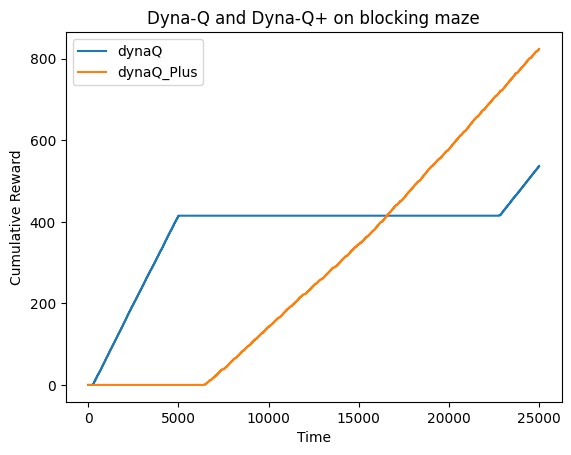

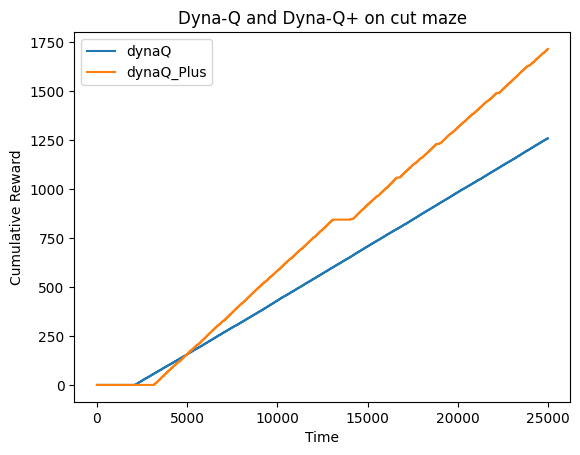

In [28]:

maze_list=["basic","blocking","cut"]
n_planning_list = [0, 5, 50] ##
agent_list=["dynaQ","dynaQplus"]
ncol = 9 ## size of env
nrow = 6 ## size of env
epsilon = 0.01 ## epsilon-greedy
alpha = 0.1 ## learning rate
gamma = 0.95 ## discount factor
kappa=1e-3  
num_episodes = 50  # num of episodes

SEED = 6657
random.seed(SEED)
np.random.seed(SEED)


##### Part 1 Visualization
##### We are going to analyse the impact of "n_planing" , we take this part in Maze "basic" and agent "DynaQ" 

for n_planning in n_planning_list:
    

    env = Maze(ncol, nrow, model="basic")
    agent_name="DynaQ"
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)

    return_list = []  
        
           
    for i_episode in range(num_episodes):  
        episode_return = 0
        state = env.reset()    # 重置环境
        done = False    # 没有完成
        t_count = 0
        while not done:
            action = agent.take_action(state)   # 选择动作
            next_state, reward, done = env.step(action)   # 做完这个动作是否到终点，需要更新这个动作
            episode_return += reward  
            t_count += 1
            agent.update(state, action, reward, next_state)  # 需要更新环境模型
            state = next_state
        return_list.append(t_count)  # 记录到终点的时间

        #return_list = DynaQ_Maza(n_planning)
        episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
        return_list,
        label=str(n_planning) + ' planning steps '+ str(agent_name))
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Step per episodes')
plt.title('Dyna-Q on {}'.format('Maze '+"basic"))
plt.show()


##### Part 2 Visualization
##### We are going to analyse the difference between agent "DynaQ" and agent "DynaQ+"

for maze in maze_list:
    for agent_type in ["dynaQ", "dynaQ_Plus"]:
        epsilon = 0.1
        alpha = 1
        gamma = 0.95
        n_planning = 20
        num_episodes = 20  


        ### reset  env
        if maze == "basic":
            env = Maze(ncol, nrow, model="basic")
        if maze == "blocking":
            env = Maze(ncol, nrow, model="blocking")
        if maze == "cut":
            env = Maze(ncol, nrow, model="cut")    

        ### reset agent
        if agent_type=="dynaQ":
            agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
        else:
            agent = DynaQ_Plus(ncol, nrow, epsilon, alpha, gamma, kappa, n_planning)



        time_step = 0
        cumulative_reward = np.zeros(25000)

        while time_step < 25000:
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                time_step += 1
                if time_step>=25000:
                    break
                cumulative_reward[time_step] = cumulative_reward[time_step-1] + reward
                agent.update(state, action, reward, next_state)
                state = next_state
        time_list = list(range(len(cumulative_reward)))
        plt.plot(time_list, cumulative_reward, label = agent_type)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Dyna-Q and Dyna-Q+ on {}'.format(maze + ' maze'))
    plt.show()

**Questions.**

**(a)** What are the impacts of the number of planning steps on the performances of algorithms and
what is the reason?

**Answer**: 

Impact: The more steps taken in the planning, the faster the total number of steps needed to reach the end converges.

Reason: For a simple and deterministic environment, using a large number of planning steps can allow the algorithm to quickly learn the environment model and select the optimal action, so as to converge to the optimal strategy faster

**(b)** What are the differences between the performance of Dyna-Q and that of Dyna-Q+ in three
environments? Please discuss the reason for these differences

**Answer**:

The difference between Dyna-Q and Dyna-Q+ is that the latter adds a time-related increment to the original reward in the planning process $c\cdot\sqrt{tau}$. It plays the role of encouraging the exploration of states that have not been accessed for a long time during planning and alleviates the problem of inaccurate model learning.

Describe the performance and causes of Dyna-Q and Dyna-Q+ in three environments:

In the first environment, Dyna-Q performs slightly better than Dyna-Q+. Because the latter encourages planning to access states with large access intervals, which leads to the fact that even when the learned model is already accurate enough in the later stage, the update of the Q function in planning does not follow the real situation reward, resulting in a seemingly improved reward, but in fact the learned Q does not correspond to the optimal case.

In the second environment, Dyna-Q+ performes significantly better than Dyna-Q. In the intermediate stage Dyna-Q shows reward stagnation because of the change of the environment——the original optimal path failed, and the original path that could not pass became optimal. Dyna-Q+ encouraging exploration helps detect changes of the environment earlier, while Dyna-Q completely follows the old model and policy and takes a longer time to learn the changes of the environment.

In the third environment, Dyna-Q is better than Dyna-Q+ at the beginning, and Dyna-Q+ surpasses Dyna-Q as the environment changes. Unlike environment 2, the original optimal path of environment 3 is still accessible after the change, but there occurs another better path. Dyna-Q will always follow the learned model and Q function(policy) to act, while the exploration of Dyna-Q+ makes it discover the emergence of the better path, which leads to the improvement of performance.


# Section 2：Advantage ActorCritic algorithm (A2C)

## Policy Gradient
We need parametrized strategy for the policy based method. We assume the target strategy $\pi_\theta$ is a stochastic policy and is differentiable everywhere, where $\theta$ is the corresponding parameter. Our goal is to find an optimal strategy to maximize the expected reward of this strategy in the environment. We define the object function of our strategy learning as:
$$
J(\theta)= V^{\pi_\theta}(s_0),
$$
where $s_0$ is the initial state.Now with the object function, we compute its derivation over the strategy $\theta$, and use gradient-ascent to maximize the object function and get the optimal policy.

We have learned the state access distribution under policy $\pi$，and here we denote it as $d^{\pi}$. Then we compute the gradient of the object function and get

$$
\begin{align}
\nabla_{\theta}J(\theta)
&\propto \sum_{s \in S}d^{\pi}(s)\sum_{a \in A}Q^{\pi}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)\\
&=\sum_{s \in S}d^{\pi}(s)\sum_{a \in A}\pi_{\theta}(a|s)Q^{\pi}(s,a)\frac{\nabla_{\theta}\pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
&= \mathbb{E}_{\pi}[Q^{\pi}(s,a)\nabla_{\theta}\ln \pi_{\theta}(a|s)]
\end{align}.
$$
So, we can use the gradient to update the policy. However, in practice, we generally write the gradient as
$$
g = \mathbb{E}[\sum^{\infty}_{t=0}\psi_{t} \nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})],
$$
where $\psi_{t}$ can be one of the following (but not limited to these forms):
$$
\psi_t=
\begin{cases}
    G_t \\
    Q^{\pi}(s_t,a_t) \\
    Q^{\pi}(s_{t},a_{t})-V^{\pi}(s_{t}) \\
    r_{t} + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t)
\end{cases}
$$

You probably have noticed that all these definitions of $\psi_t$ are basically an estimator of $Q^\pi(s,a)$ (recall that $G_t$ and $r_t + \gamma V^\pi(s_{t+1})$ are MC and TD estimators, respectively), possibly with a subtracted baseline, namely the value function $V^\pi(s_t)$. We will prove that the subtracted baseline doesn't introduce bias in the following question, which means we are still maximizing the expected reward.

However, the story doesn't end here. Subtracting a baseline helps us reduce variance (recall how TD outperforms MC in previous homeworks by reducing the variance). In the following experiments we will visualize the impact of the baseline on the performance of Actor-Critic algorithm. In fact, we can prove the reduction in variance and figure out which baseline minimizes the variance. For those interested, please refer to online materials like [this page](https://davidrosenberg.github.io/ttml2021fall/bandits/6.PG-variance-reduction.pdf).

**Question**: Let $f$ be a function that maps the state space $\mathcal{S}$ to $\mathbb{R}$, $\pi_\theta$ be the policy induced by parameter $\theta$, and $\rho^{\pi_\theta}(s)$ be the state occupancy measure of $\pi_\theta$. Prove that $\mathbb{E}_{\pi_\theta} \left[ \frac{\partial \log \pi_\theta(a|s)}{\partial \theta} f(s) \right] = 0$. Here the expectation is taken over the possible trajectories including visited states and actions generated by policy $\pi_\theta$, i.e. $\text{LHS} = \sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s) \sum_{a\in\mathcal{A}} \pi_\theta(a|s) \left( \frac{\partial \log \pi_\theta(a|s)}{\partial \theta} f(s) \right)$.

**Proof**: Your proof here.

  $\quad \mathbb{E}_{\pi_\theta} \left[ \frac{\partial \log \pi_\theta(a|s)}{\partial \theta} f(s) \right]$
 
  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s) \sum_{a\in\mathcal{A}} \pi_\theta(a|s) \left( \frac{\partial \log \pi_\theta(a|s)}{\partial \theta} f(s) \right)$

  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s)\cdot f(s) \sum_{a\in\mathcal{A}} \left(\pi_\theta(a|s) \frac{\partial \log \pi_\theta(a|s)}{\partial \theta}  \right)$

  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s)\cdot f(s) \sum_{a\in\mathcal{A}} \frac{\partial\pi_\theta(a|s)}{\partial \theta}$

  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s)\cdot f(s)\cdot \frac{\partial}{\partial \theta}\sum_{a\in\mathcal{A}} \pi_\theta(a|s)$

  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s)\cdot f(s)\cdot \frac{\partial}{\partial \theta} 1$

  $=\sum_{s\in\mathcal{S}} \rho^{\pi_\theta}(s)\cdot f(s)\cdot 0$

  $=0$


## Advantage ActorCritic (A2C) algorithm

The Advantage ActorCritic algorithm is: 
$$

\psi_{t}=r_{t} + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t).

$$

The updating procedure is：
$$
\begin{align}
&\text{1.Initialize the strategy parameter} \quad \theta \\
&\text{2.Use current strategy} \pi_{\theta} \text{to sample the trajectory} \quad \{s_{1},a_{1},r_{1},s_{2},a_{2},r_{2} ... s_{t},a_{t},r_{t}\}\\
&\text{3.Compute the reward of the current trajectory} \quad \sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'} \text{ as } \psi_{t}\\
&\text{4.Update over} \quad \theta: \theta = \theta + \alpha \psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})\\
&\text{5.Repeat step} \quad 2-4
\end{align}
$$

Alright! Now let's see how it performes using python!

## Implementation
We experiment the A2C algorithm in the Cartpole environment. The action space is discrete. First we load packages.

In [1]:
import gym
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Categorical, Normal
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import random

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
eps = np.finfo(np.float32).eps.item()
device

'cpu'

In [2]:
def smooth_curve(y, smooth):
    r = smooth
    length = int(np.prod(y.shape))
    for i in range(length):
        if i > 0:
            if (not np.isinf(y[i - 1])) and (not np.isnan(y[i - 1])):
                y[i] = y[i - 1] * r + y[i] * (1 - r)
    return y

def moving_average(y, x=None, total_steps=100, smooth=0.9, move_max=False):
    if isinstance(y, list):
        y = np.array(y)
    length = int(np.prod(y.shape))
    if x is None:
        x = list(range(1, length+1))
    if isinstance(x, list):
        x = np.array(x)
    if length > total_steps:
        block_size = length//total_steps
        select_list = list(range(0, length, block_size))
        select_list = select_list[:-1]
        y = y[:len(select_list) * block_size].reshape(-1, block_size)
        if move_max:
            y = np.max(y, -1)
        else:
            y = np.mean(y, -1)
        x = x[select_list]
    y = smooth_curve(y, smooth)
    return y, x
def plotReward(infos):
    x, y = infos["episodes"],infos["rewards"]
    y, x = moving_average(y, x)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(x, y)
    plt.show()

Define basic network unit Net.

In [3]:
class Net(torch.nn.Module):
    def __init__(self, hidden_size, input_size, output_size, layer_num=2):
        super(Net, self).__init__()
        # Use torch.nn.ModuleList or torch.nn.Sequential For multiple layers
        layers = []
        last_size = input_size
        for i in range(layer_num-1):
            layers.append(torch.nn.Linear(last_size, hidden_size))
            layers.append(torch.nn.ReLU())
            last_size = hidden_size
        layers.append(torch.nn.Linear(last_size, output_size))
        self._net = torch.nn.Sequential(*layers)
        # 一个简单的input->output网络

    def forward(self, inputs):
        return self._net(inputs)

Define basic class RLAlgo in the A2C algorithm.

**Coding exercise.** Please implement function dist to calculate probability of action.

In [28]:
def trans2tensor(batch):
    # 将数据转化为tensor
    for k in batch:
        # print(batch[k])
        if isinstance(batch[k], torch.Tensor):
            batch[k] = batch[k].to(device=device)
        elif isinstance(batch[k][0], torch.Tensor):
            batch[k] = torch.cat(batch[k]).to(device=device)
        else:
            batch[k] = torch.tensor(batch[k], device=device, dtype=torch.float32)

    return batch


class RLAlgo:
    # RL算法基类
    def __init__(self, discrete_action=True, tau=0.01):
        self.discrete_action = discrete_action  # 是否离散化动作空间
        self._tau = tau 

    # update target network
    def soft_update(self, source, target, tau=None):
        # soft update for target value
        if tau is None:
            tau = self._tau
        with torch.no_grad():
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    # sample actions
    def action(self, state):
        with torch.no_grad():
            p_out = self.policy(state)
        log_prob, action = self.dist(p_out)  # 没有输入action
        return action, log_prob

    # calculate probability of action
    def dist(self, p_out, action=None):
        if self.discrete_action:
            """YOUR CODE HERE"""
            # ========================================
            # 【Coding 1】: Hints:
            #  1. output p_out according to the policy net，use softmax to compute the distribution of action (action_dist).
            #  2. if action is None，get action according to the action distribution；If not, use the input action.
            #  3. get the probability of each action (log_prob) according to the specific action and the distribution of action.
            # ========================================
            # 离散化动作空间
            action_dist = F.softmax(p_out, dim=-1)
            # 按照分布sample一个action
            sample = Categorical(logits=action_dist)
            action = sample.sample() if action is None else action.squeeze()  # sample出来的是(batch, 得调整一下不然计算log_prob维度会炸
            log_prob = sample.log_prob(action)
            """END CODE HERE"""
        else:
            # only for pendulum env
            mean, var = torch.chunk(p_out, 2, dim=-1)
            mean = 2 * torch.tanh(mean)
            var = torch.nn.functional.softplus(var)
            m = Normal(mean, var)
            if action is None:
                action = m.sample()
                action = torch.clamp(action, -2, 2)
            log_prob = m.log_prob(action)

        return log_prob.reshape(-1, 1), action.reshape(-1, 1)

    # compute advantage
    def compute_adv(self, batch, gamma):
        s = batch["state"]
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)
        with torch.no_grad():
            adv = r + gamma * (1 - done) * self.value(s1) - self.value(s)
        return adv

**Coding exercise.** Please implement the A2C algorithm. Note that:
- There are three network: actor network, value network and target value network. The target value network is updated by soft_update function in class RLAlgo.
- We would like to compare the performance of actor-critic algorithm between using a baseline or not (with the same estimator of Q-value). In other words, during the update of agent, the loss function is written as either $L=(r_{t} + V^{\pi}(s_{t+1}) - V^{\pi}(s_t)) \log\pi_{\theta}(a_{t}|s_{t})$ (advantageous actor-critic) or $L=(r_{t} + V^{\pi}(s_{t+1})) \log\pi_{\theta}(a_{t}|s_{t})$ (actor-critic). The parameter that determines whether we use advantage is the bool value `use_advantage`.

and computing the derivative over $\theta$ can update the policy.


In [31]:
class AdvantageActorCritic(RLAlgo):
    def __init__(
            self,
            hidden_size,
            state_space,
            action_space,
            actor_lr,
            critic_lr,  # learing rate
            use_advantage,
            **kwargs
    ):
        super(AdvantageActorCritic, self).__init__(**kwargs)
        self.action_space = action_space
        self.use_advantage = use_advantage
        # 根据状态动作空间设置网络参数
        input_size = state_space.shape[0]
        if self.discrete_action:
            output_size = action_space.n  # 输出维度为动作的个数
        else:
            # 非离散化的动作空间
            output_size = action_space.shape[0] * 2  # 输出维度为2倍动作的个数

        """YOUR CODE HERE"""
        # 初始化各种网络、环境、优化器
        # 三个网络：actor policy、critic value、target value
        self.policy = Net(hidden_size, input_size, output_size).to(device)
        self.value = Net(hidden_size, input_size, 1).to(device)  # true
        self.target_value = Net(hidden_size, input_size, 1).to(device)  # update
        self.target_value.load_state_dict(self.value.state_dict())  # 仅在初始化时执行，将value所有模型参数加载，以备后续softupdtae
        self.value_opt = torch.optim.Adam(self.value.parameters(), lr=critic_lr)  # critic
        self.policy_opt = torch.optim.Adam(self.policy.parameters(), lr=actor_lr)

        """END CODE HERE"""

    def update(self, batch, gamma):
        s = batch["state"]
        a = batch["action"].reshape(-1, 1)
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)

        """YOUR CODE HERE"""
        # "state": states, "action": acts,
        # "log_prob": log_probs,
        # "next_state": next_states, "done": dones,
        # "reward": rewards
        # batch是收集的轨迹的信息
        with torch.no_grad():
            update_value = r + gamma * (1 - done) * self.value(s1)
        if self.use_advantage:
            # 计算优势函数
            adv = self.compute_adv(batch, gamma)
        else:
            adv = update_value

        # 计算critic loss并梯度更新，后者没有梯度
        critic_loss = F.mse_loss(self.value(s), update_value)  # critic loss
        self.value_opt.zero_grad()
        critic_loss.backward()
        self.value_opt.step()

        # 更新actor
        # self.action(s)函数里面得到的没有梯度
        p_out = self.policy(s)
        # print(a)   # a*1
        # print(p_out)  # a*2
        log_prob, _ = self.dist(p_out, a)  # 已经有动作了
        # print(log_prob)
        actor_loss = torch.mean(-log_prob * adv)  # adv*log\pi
        self.policy_opt.zero_grad()
        actor_loss.backward()
        self.policy_opt.step()

        self.soft_update(self.value, self.target_value)  # update target value

        """END CODE HERE"""

Now let's do experiment and see the performance of the algorithm in Carpole environment!

In [6]:
env_name = "CartPole-v1"
env = gym.make(env_name)

In [10]:
max_timesteps = 1000
gamma = 0.98

# 定义训练函数
def train(agent, num_episode=1000, mini_epoch=5, discrete_action=True, print_every=100):
    rewards_log = []
    episodes_log = []
    for i_episode in range(num_episode):
        states = []
        acts = []
        rewards = []
        next_states = []
        log_probs = []
        dones = []

        state, _ = env.reset(seed=1)
        # env.reset(seed=1)
        random.seed(1)

        state = torch.tensor([state], device=device, dtype=torch.float32)

        # 收集轨迹 trajactory/samples
        for time_step in range(max_timesteps):
            action, log_prob = agent.action(state)
            action = action.cpu()
            if discrete_action:
                next_state, reward, done, _, _ = env.step(action.numpy().reshape(-1)[0])
            else:

                next_state, reward, done, _, _ = env.step(action.numpy().reshape(-1))

            # collect samples
            states.append(state)
            acts.append(action)
            log_probs.append(log_prob.detach())
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            # log_probs.append(log_prob)

            state = torch.tensor([next_state], device=device, dtype=torch.float32)
            if done:
                break
        rewards_log.append(np.sum(rewards))
        episodes_log.append(i_episode)
        batch = trans2tensor({"state": states, "action": acts,
                              "log_prob": log_probs,
                              "next_state": next_states, "done": dones,
                              "reward": rewards, })
        r = batch["reward"]
        if not discrete_action:
            batch["reward"] = (r - r.mean()) / (r.std() + 1e-8)
        batch["adv"] = agent.compute_adv(batch, gamma)
        # update更新阶段，输入batch是一个字典，里面包含了所有的轨迹信息
        for i in range(mini_epoch):
            agent.update(batch, gamma)
        if (i_episode + 1) % print_every == 0 or i_episode + 1 == num_episode:
            print("Episode: {}, Reward: {}".format(i_episode + 1, np.mean(rewards_log[-10:])))
    # env.close()
    infos = {
        "rewards": rewards_log,
        "episodes": episodes_log
    }
    return infos

In the CartPole-v1 environment，let's see how each Episode scores when using Advantageous Actor-Critic and compare them with Actor-Critic scores.

Note that the following code block can take quite a while to run. Therefore, it is recommended that you verify the correctness of your code before fully running these experiments.

Episode: 100, Reward: 29.4
Episode: 200, Reward: 17.1
Episode: 300, Reward: 16.2
Episode: 400, Reward: 11.6
Episode: 500, Reward: 11.8
Episode: 600, Reward: 14.8
Episode: 700, Reward: 10.7
Episode: 800, Reward: 11.9
Episode: 900, Reward: 12.4
Episode: 1000, Reward: 12.2
Episode: 1100, Reward: 12.0
Episode: 1200, Reward: 10.6
Episode: 100, Reward: 20.1
Episode: 200, Reward: 14.1
Episode: 300, Reward: 11.0
Episode: 400, Reward: 21.5
Episode: 500, Reward: 38.9
Episode: 600, Reward: 55.6
Episode: 700, Reward: 56.9
Episode: 800, Reward: 59.8
Episode: 900, Reward: 53.2
Episode: 1000, Reward: 42.4
Episode: 1100, Reward: 61.0
Episode: 1200, Reward: 75.9
Episode: 100, Reward: 17.8
Episode: 200, Reward: 40.2
Episode: 300, Reward: 36.9
Episode: 400, Reward: 64.1
Episode: 500, Reward: 71.2
Episode: 600, Reward: 110.9
Episode: 700, Reward: 76.0
Episode: 800, Reward: 120.6
Episode: 900, Reward: 103.4
Episode: 1000, Reward: 121.4
Episode: 1100, Reward: 133.4
Episode: 1200, Reward: 93.3


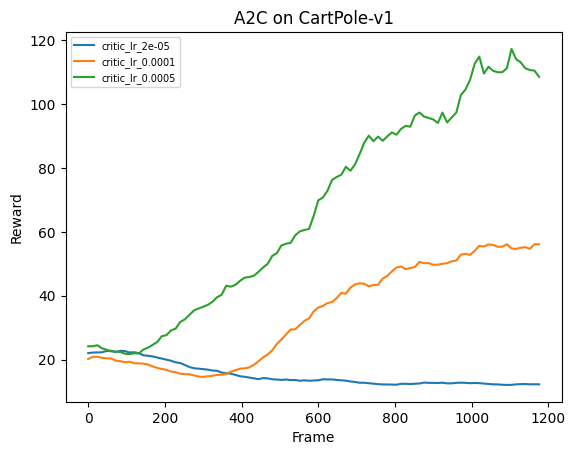

Episode: 100, Reward: 18.7
Episode: 200, Reward: 21.3
Episode: 300, Reward: 25.7
Episode: 400, Reward: 25.8
Episode: 500, Reward: 32.9
Episode: 600, Reward: 31.9
Episode: 700, Reward: 51.3
Episode: 800, Reward: 45.3
Episode: 900, Reward: 63.2
Episode: 1000, Reward: 33.6
Episode: 1100, Reward: 47.1
Episode: 1200, Reward: 56.7


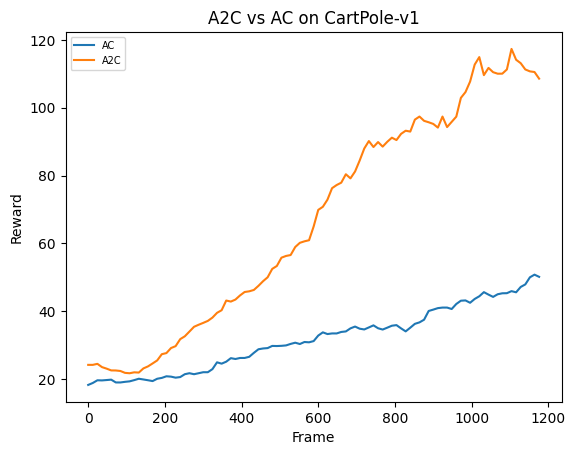

In [33]:
actor_lr = 1e-4
critic_lr = [2e-5, 1e-4, 5e-4,]
infos_by_lr = {}

hidden_size = 128
train_episodes = 1200
mini_epochs = 10

plt.title('A2C on {}'.format(env_name))
plt.ylabel("Reward")
plt.xlabel("Frame")

for i in range(len(critic_lr)):
    agent = AdvantageActorCritic(
        hidden_size,
        env.observation_space,
        env.action_space,
        actor_lr,
        critic_lr[i],
        use_advantage=True,
    )
    a2c_cartpole_infos = train(agent, train_episodes, mini_epochs)
    infos_by_lr[critic_lr[i]] = a2c_cartpole_infos
    infos = [a2c_cartpole_infos, ]
    for info in infos:
        x, y = info["episodes"], info["rewards"]
        y, x = moving_average(y, x)
        plt.plot(x, y, label='critic_lr_'+str(critic_lr[i]))

plt.legend(prop={"size": 7})
# plt.ylim(top=700)
plt.show()
plt.clf()


plt.title('A2C vs AC on {}'.format(env_name))
plt.ylabel("Reward")
plt.xlabel("Frame")
ac_critic_lr_idx = 2
ac_critic_lr = critic_lr[ac_critic_lr_idx]
agent = AdvantageActorCritic(
    hidden_size,
    env.observation_space,
    env.action_space,
    actor_lr,
    ac_critic_lr,
    use_advantage=False,
)
ac_cartpole_infos = train(agent, train_episodes, mini_epochs)
infos = [ac_cartpole_infos, infos_by_lr[ac_critic_lr], ]
for info in infos:
    x, y = info["episodes"], info["rewards"]
    y, x = moving_average(y, x)
    plt.plot(x, y)

plt.legend(['AC', 'A2C'], prop={"size": 7})
plt.show()

**Question**: What can you infer from the plot about the relationship between the learning rate of critic and action?

**Answer**: 

As shown in the first graph with the code, when the critic lr is less than actor lr, the algorithm performs very poorly, and vice versa, the larger the better. Analyze the reason.

When the critic as a mentor has a smaller learning rate than the actor, it learns slower than the actor and the ability to judge better choices at the same time is weaker than actor, so the results are worse. 

When the learning rate of the actor and critic is equal, the performance is not good at first and then increases. That because the critic's learning results(value) gets better and better as the training. 

When the critic lr is greater than actor lr, the ability of the critic to judge is stronger than actor at the same time, making critic a good mentor. 

Overall, when the critic lr is slightly greater than the actor lr, it performs best.

**Question**: How is the performance of A2C (taking value function as a baseline) compared to AC (not using a baseline)? What could be the reason?

**Answer**: 

As shown in the second graph, A2C performs better than AC obviously. That because A2C uses an advantage function to update policy, which reduces the varience of evaluation of the (s,a) or to say the policy gradient. What's more, the advantage function makes good action gradient positive and bad action gradient negative, which makes the policy update directions more clear. Overall, A2C performs better than AC.